# Check the Python version being used

In [1]:
!python --version

Python 3.7.6


# Check that the available gpu is being utilized

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available")
print(len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available
1


# Start of second method of lstm time series forecasting

In [4]:
from pandas import read_csv

df = read_csv('Time_Series_For_Clustering_El_Paso_Final.csv')

# get each separate time series as an individual list and append each of these lists to a master list

In [5]:
import re
import pandas as pd

non_decimal = re.compile(r'[^\d.]+')

list_of_training_df = []
list_of_row_components = []

for i in range(1, 524):
    
    current_row = df.iloc[i]
    
    bridge_id = current_row.iloc[0]
    
    current_row = current_row.iloc[1:]
    
    for j, row in current_row.iteritems():
        
        current_row_components = row.split(', ')
        current_row_components_replaced = []

        for idx, component in enumerate(current_row_components):

            result = non_decimal.sub('', current_row_components[idx])
            current_row_components_replaced.append(float(result))

        list_of_row_components.append(current_row_components_replaced)

# Ensure each element in the list of lists is a float

In [6]:
for idx, element in enumerate(list_of_row_components):
    for i in range(1, len(element)):
        list_of_row_components[idx][i] = float(list_of_row_components[idx][i])

# View one time series

In [7]:
for i in range(22):
    print(list_of_row_components[i])

[36.0, 97.0, 428.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.3, 97.0, 955.0, 1949.0, 2.0, 11.0, 7.0]
[36.3, 96.9, 955.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 97.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 522.0, 1949.0, 2.0, 9.7, 7.3]


# Get length of list of lists

In [8]:
len(list_of_row_components)

11506

# Swap last entry with second entry in time series to make the output predictor variable Sufficiency Rating

In [9]:
for idx, component in enumerate(list_of_row_components):
    temp = component[6]
    list_of_row_components[idx][6] = list_of_row_components[idx][1]
    list_of_row_components[idx][1] = temp

# Convert format of list to have a single time series for each index

In [10]:
import numpy as np

list_of_examples = []
temp_list = []

max_num = 22
iter = 0;

for row_component in list_of_row_components:
    if iter == max_num:
        list_of_examples.append(np.array(temp_list))
        temp_list = []
        iter = 0
        
    temp_list.append(np.array(row_component))
    iter += 1

list_of_examples = np.array(list_of_examples)

# Make the very last time step of each time series just a single value (Sufficiency Rating) for the model to predict on

In [11]:
for idx, example in enumerate(list_of_examples):
    list_of_examples[idx][21] = [list_of_examples[idx][21][6]]

# Perform train test split for dataset

In [12]:
from sklearn.model_selection import train_test_split

n_train_periods = 300
train = list_of_examples[:n_train_periods, :]
test = list_of_examples[n_train_periods:, :]

# split into input and outputs
train_X, train_y = train[:, :-1, 1:], train[:, -1, 0]
test_X, test_y = test[:, :-1, 1:], test[:, -1, 0]


In [13]:
print("Shape of train_X: " + str(train_X.shape))
print("Shape of train_y: " + str(train_y.shape))
print("Shape of test_X: " + str(test_X.shape))
print("Shape of test_y: " + str(test_y.shape))

Shape of train_X: (300, 21, 6)
Shape of train_y: (300,)
Shape of test_X: (222, 21, 6)
Shape of test_y: (222,)


# Build simple Dense model

In [14]:
bidirectional_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2]))),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1)
])

# Compile model

In [15]:
bidirectional_lstm_model.compile(loss='mae', optimizer='adam')

# Train model

In [16]:
history = bidirectional_lstm_model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
10/10 - 1s - loss: 81.6910 - val_loss: 74.5561
Epoch 2/100
10/10 - 1s - loss: 79.9053 - val_loss: 73.0720
Epoch 3/100
10/10 - 1s - loss: 78.2443 - val_loss: 71.2474
Epoch 4/100
10/10 - 1s - loss: 76.1457 - val_loss: 69.1361
Epoch 5/100
10/10 - 1s - loss: 73.7319 - val_loss: 66.9373
Epoch 6/100
10/10 - 1s - loss: 70.8858 - val_loss: 64.2275
Epoch 7/100
10/10 - 1s - loss: 67.4324 - val_loss: 61.2190
Epoch 8/100
10/10 - 1s - loss: 63.3021 - val_loss: 57.1381
Epoch 9/100
10/10 - 1s - loss: 58.2810 - val_loss: 52.6690
Epoch 10/100
10/10 - 1s - loss: 52.5067 - val_loss: 47.8462
Epoch 11/100
10/10 - 1s - loss: 45.6145 - val_loss: 42.8706
Epoch 12/100
10/10 - 1s - loss: 38.8242 - val_loss: 37.3091
Epoch 13/100
10/10 - 1s - loss: 31.8485 - val_loss: 31.7272
Epoch 14/100
10/10 - 1s - loss: 25.8140 - val_loss: 26.4888
Epoch 15/100
10/10 - 1s - loss: 21.8277 - val_loss: 22.3188
Epoch 16/100
10/10 - 1s - loss: 18.3054 - val_loss: 19.0732
Epoch 17/100
10/10 - 1s - loss: 16.2514 - val_los

# Plot model loss and validation loss

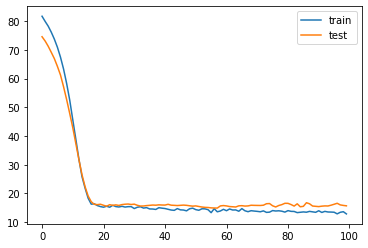

In [17]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# We now get the RMSE for both train and test sets to see if they differ by much

# Make predictions based on train set and get a root mean squared error 

In [18]:
from sklearn.metrics import mean_squared_error
import math

train_yhat = bidirectional_lstm_model.predict(train_X)
mse = mean_squared_error(train_y, train_yhat)
rmse = math.sqrt(mse)

In [19]:
print('Train RMSE: ' + str(rmse))

Train RMSE: 19.08313627266564


# Make predictions based on test set and get a root mean squared error 

In [20]:
from sklearn.metrics import mean_squared_error
import math

test_yhat = bidirectional_lstm_model.predict(test_X)
mse = mean_squared_error(test_y, test_yhat)
rmse = math.sqrt(mse)

In [21]:
print('Test RMSE: ' + str(rmse))

Test RMSE: 18.892682625706126


# Plot train labels along with train predictions

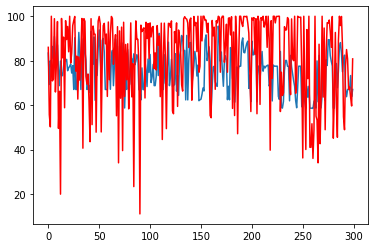

In [22]:
from matplotlib import pyplot

pyplot.plot(train_yhat, label='actual')
pyplot.plot(train_y, color='red', label='predicted')
pyplot.show()

# Plot test labels along with test predictions

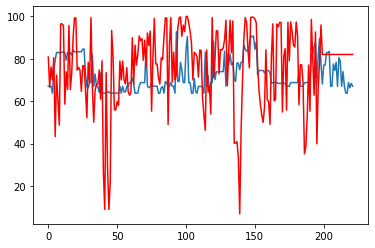

In [23]:
from matplotlib import pyplot

pyplot.plot(test_yhat, label='actual')
pyplot.plot(test_y, color='red', label='predicted')
pyplot.show()